# **Dataset Link and Online Library**
We will be using CIFAR-10, which is:

An open dataset of 60,000 color images (32x32 pixels).

10 classes (like airplane, car, dog, etc.).

Comes preloaded with torchvision.datasets, so no need to manually download anything when using PyTorch.

*   CIFAR-10 dataset official source:https://www.cs.toronto.edu/~kriz/cifar.html
*   PyTorch documentation link: https://pytorch.org/vision/stable/datasets.html#cifar10


# **Step 1: Install and Import Dependencies**

In [14]:
# No installation needed in Colab; import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import time


# [**Import/Load Data**](https://)

# **Step 2: Data Preparation and Normalization**
### CNNs *converge* faster and more accurately when input values are standardized.



In [15]:
# Transform: Normalize to [-1, 1] range
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# **Import/Load Data**

In [22]:

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)




# **Data Loader**

What it does:
* Wraps the training dataset (trainset) in a DataLoader object.

* Loads data in mini-batches of 64 images at a time.

* Shuffles the training data at every epoch to prevent the model from learning the order of the data.

Why it's important:
* Mini-batch training is efficient for memory and speeds up training using parallel computation.

* Shuffling adds randomness, which helps generalize the model and avoid overfitting to the data sequence.

Test DataLoader:
* Keep order for consistent, fair evaluation

In [23]:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# **Image Size and Number of Images**

In [20]:
# check the size of the images and number of samples in training/testing sets:

print("Number of training images:", len(trainset))
print("Number of testing images:", len(testset))

# Shape of a single image
image, label = trainset[0]
print("Shape of each image:", image.shape)


Number of training images: 50000
Number of testing images: 10000
Shape of each image: torch.Size([3, 32, 32])


In [21]:
image, label = trainset[0]
print("Image tensor shape:", image.shape)  # Output: torch.Size([3, 32, 32])


Image tensor shape: torch.Size([3, 32, 32])


# **Print Labels and Sample Image Names**

In [5]:
from collections import Counter

# CIFAR-10 classes
print("Classes:", trainset.classes)

# Count images per class
label_names = trainset.classes
all_labels = [label for _, label in trainset]
label_counts = Counter(all_labels)

print("\nImages per class:")
for label_idx, count in label_counts.items():
    print(f"{label_names[label_idx]}: {count}")


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Images per class:
frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000


# **Show Input Images and Labesl**

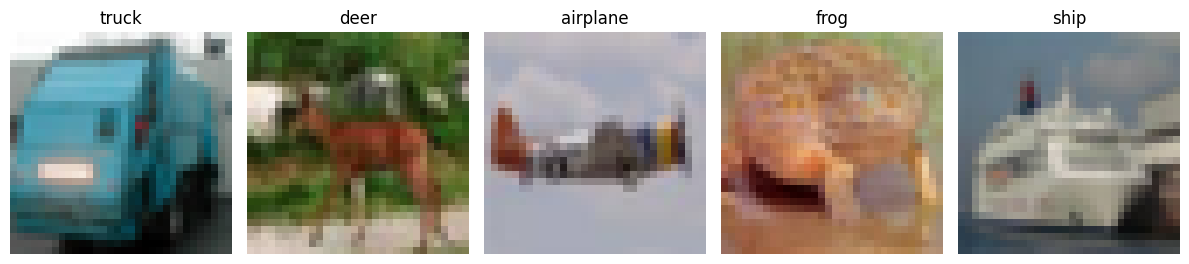

In [36]:

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Unnormalize function
def unnormalize(img):
    img = img / 2 + 0.5  # Reverse normalization
    return img.numpy()

# Display 5 images
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img = unnormalize(images[i])
    ax = axes[i]
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(trainset.classes[labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()


# **Step 3: Define the CNN Model**

In [37]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # number of filters 32
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Dropout after flattening (before fully connected layers)
        self.dropout = nn.Dropout(0.5)  # 50% dropout rate
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.dropout(x) #Regularization (prevent overfitting)
        x = torch.relu(self.fc1(x)) # connected layer
        x = self.fc2(x) #Final output (class scores)
        return x


In [ ]:
# def forward(self, x):
#     # x: [1, 3, 32, 32] = batch of 1 RGB image

#     x = self.pool(torch.relu(self.conv1(x)))
#     # conv1: 3→32 filters, padding=1, kernel=3 → output: [1, 32, 32, 32]
#     # maxpool(2x2): downsample → [1, 32, 16, 16]

#     x = self.pool(torch.relu(self.conv2(x)))
#     # conv2: 32→64 filters → [1, 64, 16, 16]
#     # maxpool(2x2) → [1, 64, 8, 8]

#     x = x.view(-1, 64 * 8 * 8)  # flatten → [1, 4096]

#     x = torch.relu(self.fc1(x))  # [1, 512]
#     x = self.fc2(x)              # [1, 10] — logits for 10 classes

#     return x


## Input Layer
- **Input size**: `3 x 32 x 32` (RGB image from CIFAR-10)
- 3 channels: Red, Green, Blue

## Convolutional Layer 1: `conv1`
- `nn.Conv2d(3, 32, kernel_size=3, padding=1)`
- Input channels: 3  
- Output channels (filters): 32  
- Kernel size: 3×3  
- Padding: 1 → keeps size `32×32`  
- Output feature map size **before pooling**: `32 × 32 × 32`

## MaxPooling Layer 1
- `nn.MaxPool2d(kernel_size=2, stride=2)`
- Downsamples by half  
- Output size after pooling: `32 × 16 × 16`

## Convolutional Layer 2: `conv2`
- `nn.Conv2d(32, 64, kernel_size=3, padding=1)`
- Input channels: 32  
- Output channels: 64  
- Kernel size: 3×3  
- Padding: 1  
- Output size before pooling: `64 × 16 × 16`

## MaxPooling Layer 2
- Output size after pooling: `64 × 8 × 8`

## Flattening Layer
- Converts 3D feature maps to 1D vector: `64 * 8 * 8 = 4096`
- Used: `x.view(-1, 64 * 8 * 8)`
- **Alternative**: Use `nn.Flatten()` for cleaner code

## Fully Connected Layer 1: `fc1`
- `nn.Linear(4096, 512)`
- Input features: 4096  
- Output features: 512

## Fully Connected Layer 2: `fc2`
- `nn.Linear(512, 10)`
- 10 outputs → one for each class in CIFAR-10

# Padding: Why and When?

- **Padding = 1** is used to **preserve input size** during convolution
- Without padding, size shrinks:  
  E.g., `32×32 → 30×30 → ...` (too fast!)
- Helps retain edge information and keeps architecture clean

# Parameter Count (Learnable Weights)

| Layer       | Formula                                  | Parameters |
|-------------|-------------------------------------------|------------|
| Conv1       | `(3×3×3)×32 + 32`                         | 896        |
| Conv2       | `(3×3×32)×64 + 64`                        | 18,496     |
| FC1         | `4096×512 + 512`                          | 2,097,664  |
| FC2         | `512×10 + 10`                             | 5,130      |
| **Total**   |                                           | **2,122,186** |

## Visualize Architecture


```bash
!pip install torchsummary
```
```python
from torchsummary import summary
summary(SimpleCNN().to('cpu'), (3, 32, 32))

```

In [38]:
!pip install torchsummary

In [39]:
from torchsummary import summary
summary(SimpleCNN().to('cpu'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                  [-1, 512]       2,097,664
            Linear-7                   [-1, 10]           5,130
Total params: 2,122,186
Trainable params: 2,122,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.50
Params size (MB): 8.10
Estimated Total Size (MB): 8.61
----------------------------------------------------------------


# **Step 4: Model Setup**

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adaptive learning rate works better for most image tasks compared to SGD.




# **Step 5: Train the Model**

In [41]:
train_losses, train_acc, test_acc = [], [], []  # Lists to store training loss, training accuracy, and test accuracy
epochs = 10  # Number of training cycles over the entire dataset

for epoch in range(epochs):
    model.train()  # Set the model to training mode (activates dropout/batchnorm if present)
    correct, total, running_loss = 0, 0, 0.0  # Reset metrics for each epoch

    for images, labels in trainloader:  # Iterate through training data in batches
        images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU

        optimizer.zero_grad()  # Clear previous gradients to avoid accumulation
        outputs = model(images)  # Forward pass: compute predictions
        loss = criterion(outputs, labels)  # Compute loss between predictions and true labels
        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model weights

        running_loss += loss.item()  # Accumulate total loss for this epoch
        _, preds = torch.max(outputs.data, 1)  # Get predicted class with highest score
        total += labels.size(0)  # Total number of samples seen
        correct += (preds == labels).sum().item()  # Count correct predictions

    # After one epoch, calculate and store average loss and training accuracy
    train_losses.append(running_loss / len(trainloader))
    train_acc.append(100 * correct / total)

    # ------------------ Testing Phase ------------------
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    test_correct, test_total = 0, 0

    with torch.no_grad():  # No need to calculate gradients during evaluation (faster, saves memory)
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass only
            _, preds = torch.max(outputs.data, 1)  # Predicted classes
            test_total += labels.size(0)  # Total test samples
            test_correct += (preds == labels).sum().item()  # Count correct predictions

    test_acc.append(100 * test_correct / test_total)  # Store test accuracy

    # Print epoch summary: loss, training accuracy, and test accuracy
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} - Train Acc: {train_acc[-1]:.2f}% - Test Acc: {test_acc[-1]:.2f}%")


Epoch [1/10] - Loss: 1071.4854 - Train Acc: 50.57% - Test Acc: 61.51%
Epoch [2/10] - Loss: 803.1257 - Train Acc: 63.54% - Test Acc: 68.42%
Epoch [3/10] - Loss: 690.8266 - Train Acc: 68.70% - Test Acc: 70.53%
Epoch [4/10] - Loss: 614.8594 - Train Acc: 72.21% - Test Acc: 71.94%
Epoch [5/10] - Loss: 544.9830 - Train Acc: 75.46% - Test Acc: 74.20%
Epoch [6/10] - Loss: 490.6120 - Train Acc: 77.85% - Test Acc: 74.19%
Epoch [7/10] - Loss: 438.1480 - Train Acc: 80.33% - Test Acc: 74.21%
Epoch [8/10] - Loss: 392.1059 - Train Acc: 82.33% - Test Acc: 75.70%
Epoch [9/10] - Loss: 358.2513 - Train Acc: 83.65% - Test Acc: 75.20%
Epoch [10/10] - Loss: 322.0421 - Train Acc: 85.32% - Test Acc: 75.54%


# **Save the Trained Model (after training loop)**

In [50]:
# Save the trained model
torch.save(model.state_dict(), "simple_cnn_cifar10.pth")
print("Model saved successfully!")


Model saved successfully!


# **Load the Model Later (anywhere else)**

In [51]:
# Load model definition
model = SimpleCNN()  # Make sure class definition matches

# Load saved weights
model.load_state_dict(torch.load("simple_cnn_cifar10.pth"))
model.eval()  # Set to evaluation mode
print("Model loaded successfully!")

# download  the model
# from google.colab import files
# files.download("simple_cnn_cifar10.pth")



Model loaded successfully!


In [52]:
# import torch

# # Simulated model output: 3 samples, 4 classes
# output = torch.tensor([
#     [0.1, 0.8, 0.05, 0.05],   # class 1 is highest
#     [0.3, 0.2, 0.1, 0.4],     # class 3 is highest
#     [0.9, 0.05, 0.03, 0.02]   # class 0 is highest
# ])

# # Get max values and indices along dim=1 (across classes)
# max_vals, indices = torch.max(output, 1)

# print("Max values:", max_vals)      # [0.8, 0.4, 0.9]
# print("Predicted classes:", indices)  # [1, 3, 0]


# **Step 6: Plot Training Loss and Accuracy**

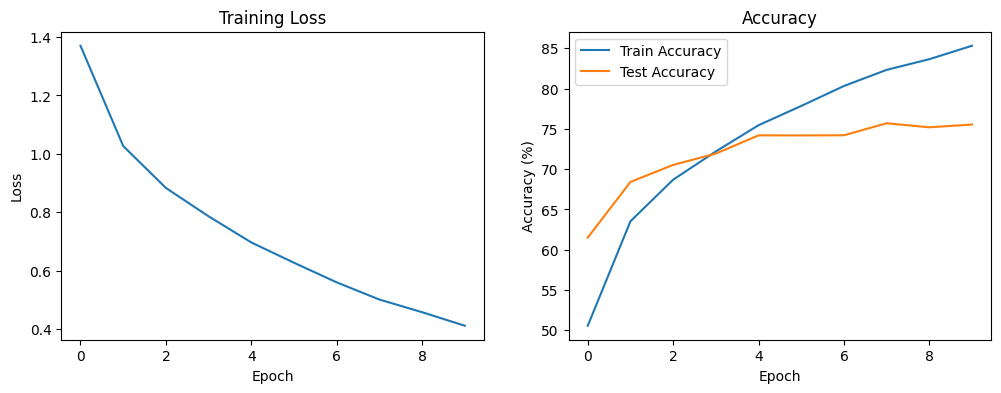

In [53]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


In [54]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nDetailed Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=trainset.classes))


Accuracy: 0.7554

Detailed Classification Report:

              precision    recall  f1-score   support

    airplane       0.78      0.79      0.78      1000
  automobile       0.90      0.81      0.86      1000
        bird       0.73      0.60      0.66      1000
         cat       0.56      0.61      0.59      1000
        deer       0.73      0.70      0.71      1000
         dog       0.64      0.68      0.66      1000
        frog       0.81      0.82      0.82      1000
       horse       0.80      0.81      0.80      1000
        ship       0.85      0.87      0.86      1000
       truck       0.78      0.86      0.82      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



# **Step 7: Confusion Matrix**

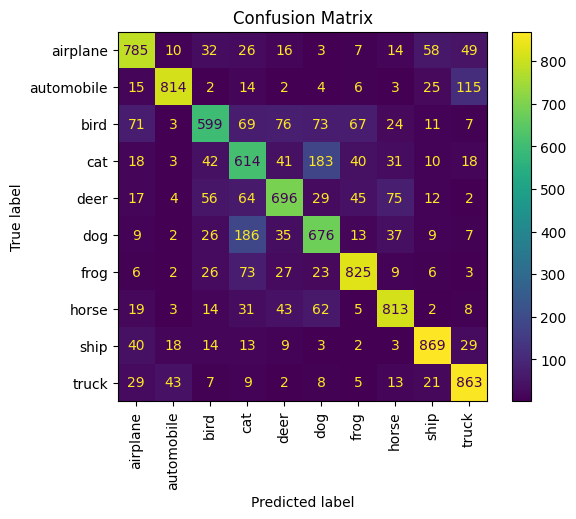

In [55]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trainset.classes)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


# **Step 8: Inference on a New Image**

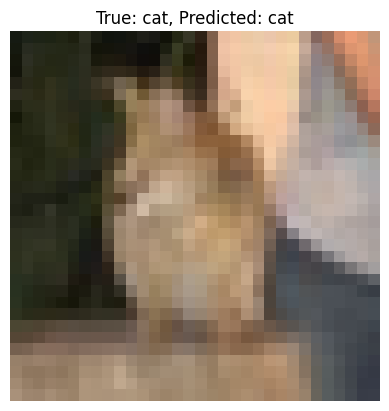

Inference Time: 0.003968 seconds


In [56]:
import random
model.eval()
test_iter = iter(testloader)
images, labels = next(test_iter)

index = random.randint(0, 63)
image = images[index].unsqueeze(0).to(device)
true_label = labels[index]

start = time.time()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)
end = time.time()

plt.imshow(np.transpose(images[index].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
plt.title(f"True: {trainset.classes[true_label]}, Predicted: {trainset.classes[predicted.item()]}")
plt.axis('off')
plt.show()

print(f"Inference Time: {(end - start):.6f} seconds")


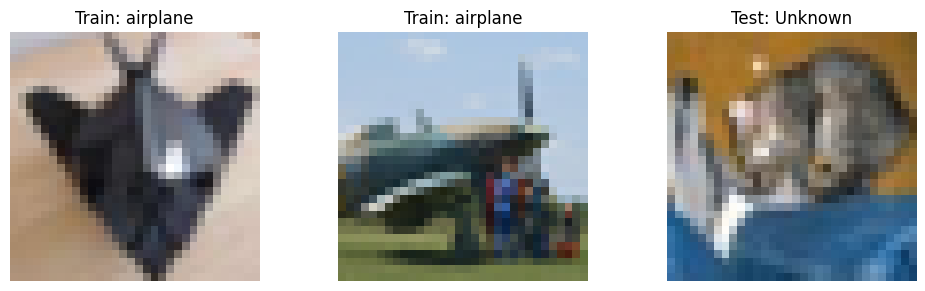

In [57]:
# Unnormalize for display
def unnormalize(img):
    img = img / 2 + 0.5
    return img.numpy()

# Get 2 training images with labels
train_iter = iter(trainloader)
train_images, train_labels = next(train_iter)

# Get 1 test image without label
test_iter = iter(testloader)
test_images, test_labels = next(test_iter)

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Show 2 training images
for i in range(2):
    img = unnormalize(train_images[i])
    axes[i].imshow(np.transpose(img, (1, 2, 0)))
    axes[i].set_title(f"Train: {trainset.classes[train_labels[i]]}")
    axes[i].axis('off')

# Show 1 test image (without label)
img = unnormalize(test_images[0])
axes[2].imshow(np.transpose(img, (1, 2, 0)))
axes[2].set_title("Test: Unknown")
axes[2].axis('off')

plt.tight_layout()
plt.show()


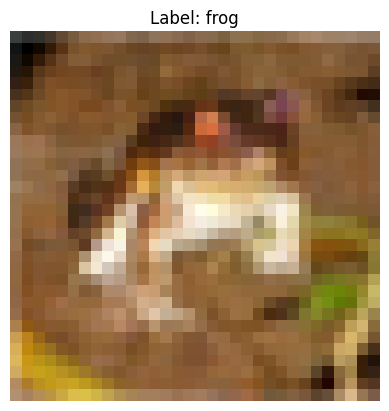

In [58]:
from torchvision import datasets
import matplotlib.pyplot as plt

# No transform → returns PIL Image
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# Get first image and label
img, label = trainset[0]

# You can show it directly!
plt.imshow(img)
plt.title(f"Label: {trainset.classes[label]}")
plt.axis('off')
plt.show()
